In [1]:
import json
import albumentations as A
from albumentations.pytorch import ToTensorV2

mod_albumentations = '[{"name": "HorizontalFlip"}, {"name": "VerticalFlip"}, {"name": "Rotate", "limit": 30}, {"name": "RandomBrightness"}, {"name": "RandomContrast"}, {"name": "ShiftScaleRotate", "shift_limit": 0.0625, "scale_limit": 0.1, "rotate_limit": 30}, {"name": "RandomGamma"}, {"name": "ElasticTransform", "alpha": 120, "sigma": 6.0, "alpha_affine": 3.6}, {"name": "GridDistortion"}, {"name": "OpticalDistortion"}, {"name": "RandomRain", "drop_length": 25, "drop_width": 1, "drop_color": [32, 32, 32], "blur_value": 7}, {"name": "RandomSnow", "snow_point_lower": 0.1, "snow_point_upper": 0.3, "brightness_coeff": 2}, {"name": "RandomFog", "fog_coef_lower": 0.3, "fog_coef_upper": 0.5, "alpha_coef": 0.08}, {"name": "RandomSunFlare", "src_radius": 32}, {"name": "RandomShadow", "shadow_dimension": 5}, {"name": "Cutout", "num_holes": 1, "max_h_size": 32, "max_w_size": 32, "p": 0.5}, {"name": "CoarseDropout", "max_holes": 1, "max_height": 32, "max_width": 32, "min_holes": null, "min_height": 8, "min_width": 8, "fill_value": 0, "p": 0.5}]'

# flare_roi	float, float, float, float	
# region of the image where flare will appear (x_min, y_min, x_max, y_max). All values should be in range [0, 1].

# angle_lower	float	
# should be in range [0, angle_upper].

# angle_upper	float	
# should be in range [angle_lower, 1].

# num_flare_circles_lower	int	
# lower limit for the number of flare circles. Should be in range [0, num_flare_circles_upper].

# num_flare_circles_upper	int	
# upper limit for the number of flare circles. Should be in range [num_flare_circles_lower, inf].

# src_radius	int	
# src_color
albumentations = json.loads(mod_albumentations.replace("'", '"'))



transform_train = []
if len(albumentations) >= 1:
    for method in albumentations:
        if type(method) == dict:
            transform_train.append(getattr(A, method.pop("name"))(**method))
        else:
            transform_train.append(getattr(A, method)())

transform_train.append(A.Resize(128, 128))
transform_train.append(
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
transform_train.append(ToTensorV2())

transform_train = A.Compose(transform_train)


/home/shivam13juna/Documents/virtual_envs/cap/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/shivam13juna/Documents/virtual_envs/cap/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/shivam13juna/Documents/virtual_envs/cap/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


# Evaluating Model

In [2]:
import os
import json
import torch
import tarfile
import subprocess
import numpy as np
import albumentations as A
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as T


from pathlib import Path
from datetime import datetime
from functools import partial
from scripts.model import LitResnet
from alibi_detect.cd import MMDDrift
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from albumentations.pytorch import ToTensorV2
from typing import Any, Dict, Optional, Tuple
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning import loggers as pl_loggers
from scripts.dataset import IntelCapstoneDataModule
from alibi_detect.cd.pytorch import preprocess_drift
from alibi_detect.models.tensorflow import scale_by_instance
from alibi_detect.saving import load_detector, save_detector
from pytorch_lightning.plugins.environments import LightningEnvironment
from alibi_detect.datasets import corruption_types_cifar10c, fetch_cifar10c

%matplotlib inline

2023-02-15 20:00:45.976518: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 20:00:46.167601: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-15 20:00:46.939054: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shivam13juna/Documents/virtual_envs/cap/lib/python3.10/site-packages/cv2/../../li

In [3]:
def eval_model(trainer, model, datamodule):
    test_res = trainer.test(model, datamodule)[0]


    # apply   
    # gaussian_noise :
#     _target_: albumentations.GaussNoise 
#     always_apply: True
#     mean: [0.485, 0.456, 0.406]

#   random_brightness:
#     _target_: albumentations.RandomBrightness 
#     always_apply: True
#     limit: 0.7
    
    # Apply gaussian noise and random brightness to the test set and check for model robustness

    # Define the transformations
    transform = A.Compose(
        [
            A.GaussNoise(mean=[0.485, 0.456, 0.406], p=1.0),
            A.RandomBrightness(limit=0.7, p=1.0),
        ]
    )

    # Apply the transformations to the test set
    test_data = np.stack([datamodule.data_test[i][0] for i in range(len(datamodule.data_test))])
    test_label = np.stack([datamodule.data_test[i][1] for i in range(len(datamodule.data_test))])

    # Apply the transformations to the test set

    mod_test_data = []
    for i in range(len(test_data)):
        value = transform(image=test_data[i].transpose(2, 1, 0))['image']
        value = value.transpose(2, 1, 0)
        mod_test_data.append(value)
    
    preds = model.forward(torch.from_numpy(np.stack(mod_test_data))) 

    acc  = (np.argmax(preds.detach().numpy(), axis=1) == test_label).sum() / len(test_label)

    acc = round(acc, 3)


    report_dict = {
        "multiclass_classification_metrics": {
            "accuracy": {
                "value": test_res["test/acc"],
                "standard_deviation": "0",
            },
            "robustness": {
                "value": acc,
                "standard_deviation": "0",
                }
        },
    }
    
    eval_folder = Path("tmp")
    
    out_path = eval_folder / "evaluation.json"
    
    print(f":: Writing to {out_path.absolute()}")
    
    with out_path.open("w") as f:
        f.write(json.dumps(report_dict))
    


   

In [4]:

model_path = "tmp/model.tar.gz"
with tarfile.open(model_path) as tar:
    tar.extractall(path=".")

datamodule = IntelCapstoneDataModule(
    train_data_dir='test/',
    test_data_dir='test/',
    num_workers=os.cpu_count(),
    albumentations = '{}'
)
datamodule.setup()

model = LitResnet.load_from_checkpoint(checkpoint_path="last.ckpt")
model.eval()


trainer = pl.Trainer(
    accelerator="auto",
)

print(":: Evaluating Model")
eval_model(trainer, model, datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


:: Evaluating Model


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.7393754124641418     │
│         test/loss         │    -3.0545125007629395    │
└───────────────────────────┴───────────────────────────┘

/home/shivam13juna/Documents/virtual_envs/cap/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


:: Writing to /home/shivam13juna/Documents/learn/tsai/emlo/sagemaker-pipeline/capstone/tmp/evaluation.json


In [5]:
test_res = trainer.test(model, datamodule)[0]

# Get the test data
test_data = datamodule.test_dataloader().dataset



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.7419582009315491     │
│         test/loss         │    -3.2169082164764404    │
└───────────────────────────┴───────────────────────────┘

In [6]:
train_data = np.stack([datamodule.data_train[i][0] for i in range(len(datamodule.data_train))])
train_label = np.stack([datamodule.data_train[i][1] for i in range(len(datamodule.data_train))])


test_data = np.stack([datamodule.data_test[i][0] for i in range(len(datamodule.data_test))])
test_label = np.stack([datamodule.data_test[i][1] for i in range(len(datamodule.data_test))])
stacked_test_data = np.stack(test_data)

In [7]:
# Make custom albumentation transform for printing image size
class CustomTransform(A.BasicTransform):
    def __init__(self, always_apply=False, p=1.0):
        super(CustomTransform, self).__init__(always_apply=True, p=1)
        
    def apply(self, img, **params):
        print(img.shape)
        return img


class PrintImageSize(A.BasicTransform):
    def __init__(self, p=1):
        super().__init__(p=p)
        
    def apply(self, img, **params):
        print("Image size:", img.shape)
        return img


transform = A.Compose(
        [
            # A.GaussNoise(mean=[0.485, 0.456, 0.406], p=1.0),
            # A.RandomBrightness(limit=0.7, p=1.0),
        A.RandomResizedCrop(32, 32,scale=(0, 0), p=1)
        ]
    )

# Apply the transformations to the test set

# mod_test_data = []
# for i in range(len(test_data)):
#     value = transform(image=test_data[i].transpose(2, 1, 0))['image']
#     value = value.transpose(2, 1, 0)
#     mod_test_data.append(value)

transform(image=test_data[0].transpose(2, 1, 0))['image'].shape

(32, 32, 3)

In [8]:
test_label

array([2, 2, 2, ..., 1, 1, 1])

In [9]:

# Get the predictions
# preds = model.forward(torch.from_numpy(stacked_test_data))

# print("Accuracy is: ", (np.argmax(preds.detach().numpy(), axis=1) == test_label).sum() / len(test_label))

In [10]:
preprocess_fn = partial(preprocess_drift, model=model, device=torch.device('cpu'), batch_size=512)

In [11]:
cd = MMDDrift(stacked_test_data, backend='pytorch', p_val=.05, preprocess_fn=preprocess_fn, n_permutations=100)

In [12]:
test_data[23].shape

(3, 128, 128)

In [13]:
stacked_test_data[23].shape

(3, 128, 128)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


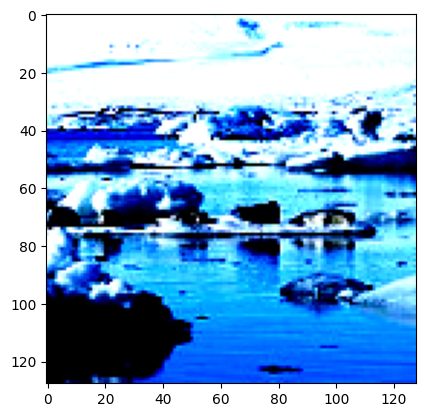

In [14]:
plt.imshow(stacked_test_data[23].transpose(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


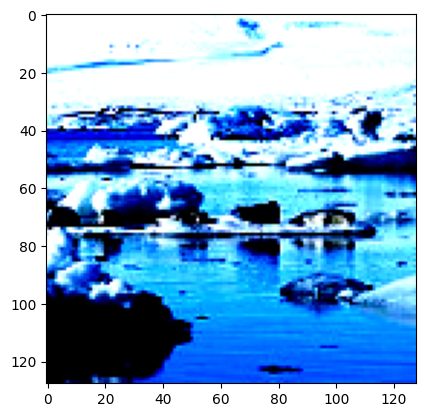

In [15]:
plt.imshow(
    torch.tensor(test_data[23]).permute(1, 2, 0)
)
plt.show()


In [16]:
label_dict = {
                "buildings": 0,
                "forest": 1,
                "glacier": 2,
                "mountain": 3,
                "sea": 4,
                "street": 5,
            }

rev_label_dict = {v: k for k, v in label_dict.items()}

In [17]:
into = np.argmax(model(torch.from_numpy(stacked_test_data)).detach().numpy(), axis=1)

In [18]:
into[:23]

array([3, 3, 2, 2, 5, 2, 4, 3, 2, 5, 2, 0, 3, 4, 2, 4, 2, 2, 2, 2, 2, 1,
       2])

In [19]:
model.training

True

In [20]:
model.eval()
sth = np.argmax(model(torch.from_numpy(stacked_test_data[:23])).detach().numpy(), axis=1)

In [23]:
(sth == into[:23]).sum()

21

In [24]:
# compare accuracy for sth and into[:23] with test_label[:23]

sth_accuracy = (sth == test_label[:23]).sum() / len(test_label[:23])

into_accuracy = (into[:23] == test_label[:23]).sum() / len(test_label[:23])


print("Accuracy for sth is: ", sth_accuracy)
print("Accuracy for into is: ", into_accuracy)



Accuracy for sth is:  0.6086956521739131
Accuracy for into is:  0.5217391304347826


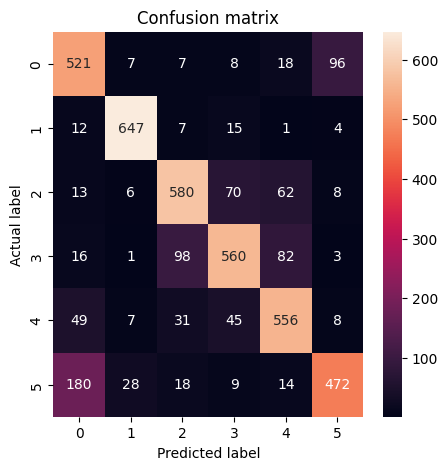

In [25]:
# plot confusion matrix using sklearn

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


cm = confusion_matrix(test_label, into)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.show()



In [26]:
print("The prediction: ", model(torch.from_numpy(test_data[23].reshape(1, 3, 128, 128))).detach().numpy())
print("np argmax is: ", np.argmax(model(torch.from_numpy(test_data[23].reshape(1, 3, 128, 128))).detach().numpy()))

The prediction:  [[-5.6051445 -6.746356  -0.4577899 -3.662245  -1.1045954 -5.212896 ]]
np argmax is:  2


In [27]:
rev_label_dict[np.argmax(model(torch.from_numpy(test_data[23].reshape(1, 3, 128, 128))).detach().numpy(), axis=1).item()]

'glacier'

In [38]:
# predicting for manual image

from PIL import Image


img = Image.open("tmp/forest.jpg")


transform_test = A.Compose(
            [
                A.Resize(128, 128),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2(),
            ]
        )

img = transform_test(image=np.array(img))['image']

pred = model(img.reshape(1, 3, 128, 128)).detach().numpy()
print("For the label forest, prediction is: ", rev_label_dict[np.argmax(pred, axis=1).item()])


img = Image.open("tmp/building.jpg")

transform_test = A.Compose(
            [
                A.Resize(128, 128),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2(),
            ]
        )

img = transform_test(image=np.array(img))['image']

pred = model(img.reshape(1, 3, 128, 128)).detach().numpy()
print("For the label building, prediction is: ", rev_label_dict[np.argmax(pred, axis=1).item()])



For the label forest, prediction is:  forest
For the label building, prediction is:  buildings
